# Dogs vs. Cats Redux: Kernels Edition

This notebook demonstrates the state of the art algorithms to distinguish cats vs dogs in images as part of the Kaggle competition **Dogs vs. Cats** https://www.kaggle.com/c/dogs-vs-cats and https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

![Cats-vs-Dogs](https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/woof_meow.jpg)


## Data 

As part of the competition, the following three datasets are provided.

* sampleSubmission.csv
* train.zip
* test1.zip

Training data consists of 25000 images of dogs and cats. Test data consists of 12500 images and our algorithm should correctly predict the lables as 1 = dog, and 0 =cat for the test images.

## Evaluation

Performance is evaluated on the percentage of correctly labeled images - accuracy

Let's take a quick look at the data

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
import re
from IPython.display import display, Image
from scipy import ndimage


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Let's take a peak at some of the data to make sure that it looks sensible. Since our data is images, we will use the IPython display package to look at the images.

In [2]:
# Set the path to the image data
#path = "/datascience/datasets/kaggle-cats-vs-dogs/original-kaggle-data/"
path = "/datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/sample/"
#path = "/datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/"

In [3]:
# Updated the function after reorganizing the data
def print_sample_images(label,sample_size):
    label_directory = path+'train/'+label+'s/'
    label_files = os.listdir(label_directory)
    #label_files = [f for f in os.listdir(label_directory) if re.match(r''+label+'.*\.jpg', f)]
    rand_smpl = [ label_directory+label_files[i] for i in sorted(random.sample(xrange(len(label_files)), sample_size))]
    print('==== Printing Images of '+label+' =====')
    for image in rand_smpl:
        display(Image(filename=image))
    pass

==== Printing Images of cat =====


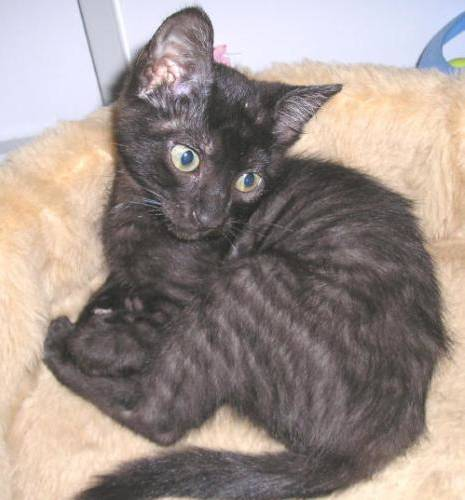

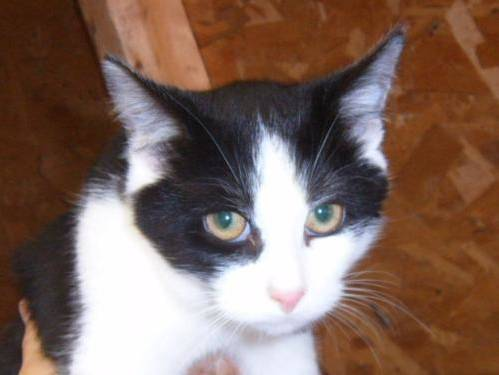

==== Printing Images of dog =====


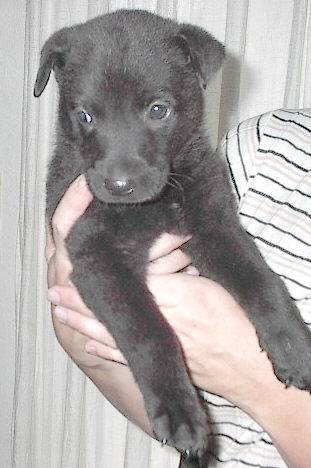

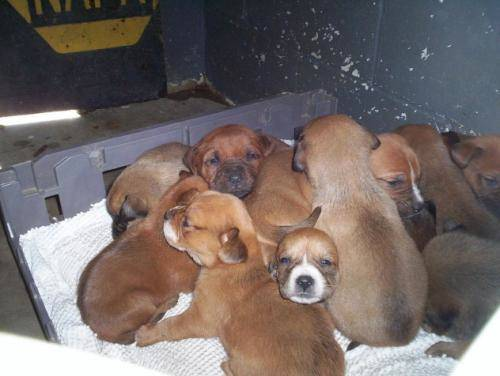

In [4]:
for label in ['cat','dog']:
    print_sample_images(label,2)

For this submission of the project, we are going to use a 2014 Imagenet winning model VGG -http://www.robots.ox.ac.uk/~vgg/research/very_deep/

We are going to use the following tools to run the VGG model
* Theano
* Keras

Here is an excellent blog on how to use the pre-trained VGG model in Keras on Cats-vs-Dogs dataset

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### Data Organization

Keras tool expects all the images in one subdirectory per class format. This is mentioned in the flow_from_directory() section of ImageDataGenerator - https://keras.io/preprocessing/image/

So let's organize the data in the following format:

* ./train/
    - dogs/
    - cats/
* ./valid/
    - train/
    - valid/
* ./test/
* ./sample/
    - train/
        - dogs/
        - cats/
    - valid/
        - dogs/
        - cats/

As part of organizing the training data into separate subdirectories for dogs and cats, we will also take a subset of the training data into a validation dataset. We will not touch the test data except to submit the predictions on Kaggle competitions. 

Validation set is very useful to train our model and tune the hyperparameters. Here is a quick introduction to why validation set is important - http://scikit-learn.org/stable/modules/cross_validation.html.

Further we will create a sample dataset from both traning and validation datasets. Since we have approximately 25000 images, it is very hard to test every step of the program for functional verification on such large dataset. In data science work, it is very helpful to create a sample dataset for quick iteration on our program logic.


Of the 25000 images in training dataset, we have 12500 images of cats and 12500 images of dogs. We will take 10% of the training dataset for validation set. So validation set will have images 1250 cats and 1250 dogs.

**Here is a list of linux commands to organize the data**

```
[gmedasani@gmds1 original-kaggle-data]$ pwd
/datascience/datasets/kaggle-cats-vs-dogs/original-kaggle-data
[gmedasani@gmds1 original-kaggle-data]$ for image in $(ls -al ./train | grep 'cat' | awk -F' ' '{print $9}'); do  mv ./train/$image /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/cats/; done
[gmedasani@gmds1 original-kaggle-data]$ for image in $(ls -al ./train | grep 'dog' | awk -F' ' '{print $9}'); do  mv ./train/$image /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/dogs/; done
```

**We can now see that the cats and dogs directories each have 12500 images**

```
[gmedasani@gmds1 cats]$ ls -ltr /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/cats/ | grep cat | wc -l
12500
[gmedasani@gmds1 cats]$ ls -ltr /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/dogs/ | grep dog | wc -l
12500
```

**Here is an example of the cat and dog images in training data in their respective sub-directories.**

```
[gmedasani@gmds1 cats]$ ls -al /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/cats/ | head -10
total 281232
drwxrwxr-x. 2 gmedasani gmedasani 327680 Jan  1 18:19 .
drwxrwxr-x. 4 gmedasani gmedasani     30 Jan  1 18:09 ..
-rw-r--r--. 1 gmedasani gmedasani  12414 Sep 20  2013 cat.0.jpg
-rw-r--r--. 1 gmedasani gmedasani  21944 Sep 20  2013 cat.10000.jpg
-rw-r--r--. 1 gmedasani gmedasani  27322 Sep 20  2013 cat.10001.jpg
-rw-r--r--. 1 gmedasani gmedasani  25723 Sep 20  2013 cat.10002.jpg
-rw-r--r--. 1 gmedasani gmedasani  28035 Sep 20  2013 cat.10003.jpg
-rw-r--r--. 1 gmedasani gmedasani  12973 Sep 20  2013 cat.10004.jpg
-rw-r--r--. 1 gmedasani gmedasani   8245 Sep 20  2013 cat.10005.jpg
[gmedasani@gmds1 cats]$ ls -al /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/dogs/ | head -10
total 328208
drwxrwxr-x. 2 gmedasani gmedasani 327680 Jan  1 18:21 .
drwxrwxr-x. 4 gmedasani gmedasani     30 Jan  1 18:09 ..
-rw-r--r--. 1 gmedasani gmedasani  32053 Sep 20  2013 dog.0.jpg
-rw-r--r--. 1 gmedasani gmedasani  16889 Sep 20  2013 dog.10000.jpg
-rw-r--r--. 1 gmedasani gmedasani   5281 Sep 20  2013 dog.10001.jpg
-rw-r--r--. 1 gmedasani gmedasani  20778 Sep 20  2013 dog.10002.jpg
-rw-r--r--. 1 gmedasani gmedasani  39597 Sep 20  2013 dog.10003.jpg
-rw-r--r--. 1 gmedasani gmedasani  42577 Sep 20  2013 dog.10004.jpg
-rw-r--r--. 1 gmedasani gmedasani  16819 Sep 20  2013 dog.10005.jpg
[gmedasani@gmds1 cats]$
```

**We can also verify that there are no cat images in dogs directory and vice-versa**

```
[gmedasani@gmds1 cats]$ ls -ltr /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/dogs/ | grep cat | wc -l
0
[gmedasani@gmds1 cats]$ ls -ltr /datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/train/cats/ | grep dog | wc -l
0
[gmedasani@gmds1 cats]$
```

Let's move 10% of the training data into validation directories.

```
[gmedasani@gmds1 kaggle-data-reorganized]$ for image in $(ls -al ./train/dogs/ | grep 'dog' | head -1250 | awk -F' ' '{print $9}'); do  mv ./train/dogs/$image ./valid/dogs/; done
[gmedasani@gmds1 kaggle-data-reorganized]$ for image in $(ls -al ./train/cats/ | grep 'cat' | head -1250 | awk -F' ' '{print $9}'); do  mv ./train/cats/$image ./valid/cats/; done

[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al train/dogs/ | grep dog | wc -l
11250
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al train/cats/ | grep cat | wc -l
11250
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al valid/dogs/ | grep dog | wc -l
1250
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al valid/cats/ | grep cat | wc -l
1250
```

We now have 11250 images for each class in training set and 1250 images for each class in validation set. Once we have a the training and validation sets created, we can take a small sample of these datasets for fast iteration.

```
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al sample/train/dogs/ | grep dog | wc -l
125
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al sample/train/cats/ | grep cat | wc -l
125
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al sample/valid/dogs/ | grep dog | wc -l
25
[gmedasani@gmds1 kaggle-data-reorganized]$ ls -al sample/valid/cats/ | grep cat | wc -l
25
[gmedasani@gmds1 kaggle-data-reorganized]$
```

Here are the commands used to create the above sample datasets

```
[gmedasani@gmds1 kaggle-data-reorganized]$ pwd
/datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized
[gmedasani@gmds1 kaggle-data-reorganized]$ for image in $(ls -al ./train/dogs/ | grep 'dog' | head -125 | awk -F' ' '{print $9}'); do  cp ./train/dogs/$image ./sample/train/dogs/; done
[gmedasani@gmds1 kaggle-data-reorganized]$ for image in $(ls -al ./train/cats/ | grep 'cat' | head -125 | awk -F' ' '{print $9}'); do  cp ./train/cats/$image ./sample/train/cats/; done

[gmedasani@gmds1 kaggle-data-reorganized]$ for image in $(ls -al ./valid/dogs/ | grep 'dog' | head -25 | awk -F' ' '{print $9}'); do  cp ./valid/dogs/$image ./sample/valid/dogs/; done
[gmedasani@gmds1 kaggle-data-reorganized]$ for image in $(ls -al ./valid/cats/ | grep 'cat' | head -25 | awk -F' ' '{print $9}'); do  cp ./valid/cats/$image ./sample/valid/cats/; done

```

## Model Setup

Here we use the pretrained VGG16 model from 2014 Imagenet to make predictions on the cats-vs-dogs redux data. To use a pre-trained model on cats-vs-dogs dataset, we need to perform the following steps.

1. **Create a network architecture same as the VGG16 architecture**
2. **Download the pre-trained weights in HDF5 format**
3. **Load the pre-trained weights**
4. **Fine-tune the model on the new dataset with only two categories cats and dogs**
5. **Fit the model on training and validation set and report the validation accuracy**
6. **Further improve the model to increase the validation accuracy**

### Create the VGG16 network architecture.

Here the VGG16 architecuture

![](https://blog.keras.io/img/imgclf/vgg16_original.png)


In [5]:
## Let's import all the modules needed to build the neural network
import keras
from keras.models import Sequential,Model
from keras.layers.core import Flatten,Dense,Dropout,Lambda
from keras.layers.convolutional import Convolution2D,MaxPooling2D,ZeroPadding2D
from keras.layers import Input
from keras.optimizers import SGD,RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import get_file

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/gmedasani/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Setup the Sequential Model

In [6]:
#Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean # subtract mean
    return x[:, ::-1] # reverse axis bgr -> rgb

In [7]:
print(vgg_mean.shape)
print(vgg_mean)

(3, 1, 1)
[[[ 123.68 ]]

 [[ 116.779]]

 [[ 103.939]]]


In [8]:
def VGG16(weights_path):
    #Instantiate a new Sequential model
    model = Sequential()
    
    # Lambda layer performs an arbitrary Theano/Tensorflow expression on the output of the previous layer
    # Here we are performing some pre-processing on the input images
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    # Convolution block 1 with 64 output filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    # Convolution block 2 with 128 output filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    # Convolution block 3 with 256 output filters 
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    # Convolution block 4 with 512 output filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    # Convolution block 5 with 512 output filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    # Fully Connectected Classifier
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    # Load pre-trained weights
    model.load_weights(weights_path)
    return model

In [9]:
#Weights with Batch Normalization layer
#vgg16_weights_file='/home/gmedasani/.keras/models/vgg16_bn.h5'

#Weights without Batch Normalization layers
vgg16_weights_file='/home/gmedasani/.keras/models/vgg16.h5'

#Let's create a model
vgg16_model = VGG16(weights_path=vgg16_weights_file)

/home/gmedasani/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [216]:
# Display the structure of the model
#vgg16_model.summary()

In [10]:
vgg16_model.layers[1].trainable

True

In [29]:
batch_size=32
class_mode='categorical'
img_size_expected=(224,224)

In [30]:
#Define a function to get the input images in batches with a size of (224,224) as that is what the VGG model expects
def get_batches(dirname,gen=ImageDataGenerator(),class_mode=class_mode,
                target_size=img_size_expected,shuffle=True,batch_size=batch_size):
    print(path+dirname)
    return gen.flow_from_directory(path+dirname,target_size=target_size,class_mode=class_mode,
                           shuffle=shuffle,batch_size=batch_size)

In [31]:
train_batches = get_batches('train',class_mode=class_mode,target_size=img_size_expected,
                            batch_size=batch_size)
valid_batches = get_batches('valid',class_mode=class_mode,target_size=img_size_expected,
                            batch_size=batch_size)

/datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/sample/train
Found 250 images belonging to 2 classes.
/datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/sample/valid
Found 50 images belonging to 2 classes.


In [32]:
train_batches.batch_size

32

In [33]:
valid_batches.batch_size

32

So far, we have done the following

1. Define the network architecture
2. Load the pre-trained weights
3. Define the training and validation batches of data with desired input shape

Next we have to fine tune the model to the cats-vs-dogs problem where we only have 2 classes, we need to do the following
1. Remove the last layer in the network 
2. Set all the weigths in the resulting network to non-trainable
3. Add a new Dense layer that only has 2 output classes instead of Imagenet's 1000
4. Set the optimizer and a loss function to optimize the model on
5. Fit the model on the training data and validation data and report training and validation accuracies

### Take the vgg16 imagenet model and make the following modifications

In [16]:
# drop the last classification layer
vgg16_model.pop()

In [17]:
len(vgg16_model.layers)

37

In [18]:
#verify that the last layer is removed
#vgg16_model.summary()

In [19]:
# Set all the weights in the remaining network to non-trainable
for layer in vgg16_model.layers: 
    layer.trainable=False

In [20]:
# In the model summary we can verify that all the previous trainable params now became non-trainable params
#vgg16_model.summary()

In [21]:
# Let's now add a new layer that only have two output classes in the final softmax layer
vgg16_model.add(Dense(2, activation='softmax'))

In [22]:
# We can now see that except for the last year's 8194 parameters, all other parameters are non-trainable.
#vgg16_model.summary()

In [23]:
# Define the optimizer you want to use for minimizing the loss.
learning_rate = 0.001
adam_optimizer = Adam(lr=learning_rate)

In [24]:
#Now let's configure the model for training using the model's compile method
vgg16_model.compile(optimizer=adam_optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [25]:
# Check the model definition again after compilation
vgg16_model.optimizer

In [26]:
print(train_batches.nb_sample)
print(valid_batches.nb_sample)

250
50


In [27]:
nb_epoch=2

In [34]:
## Fit the model on the training batches and report accuracy on the validation sets
vgg16_model.fit_generator(train_batches, 
                          samples_per_epoch=train_batches.nb_sample, 
                          nb_epoch=nb_epoch,
                          validation_data=valid_batches, 
                          nb_val_samples=valid_batches.nb_sample)

Epoch 1/2
250/250 [==============================] - 11s - loss: 0.5089 - acc: 0.8240 - val_loss: 0.1100 - val_acc: 0.9800
Epoch 2/2
250/250 [==============================] - 10s - loss: 0.1515 - acc: 0.9520 - val_loss: 0.0052 - val_acc: 1.0000

In [37]:
#Save the model weights
vgg16_model.save_weights('/home/gmeadasani/nbs/lesson1-competition/vgg16-v1-full-2eepochs-2.h5')

### Run additional two eepoch by loading the saved weights and running the fit_generator again

In [223]:
vgg16_model.load_weights('/home/gmedasani/nbs/lesson1-competition/vgg16-v1-full-2eepochs-2.h5')

In [225]:
vgg16_model.fit_generator(train_batches, 
                          samples_per_epoch=train_batches.nb_sample, 
                          nb_epoch=nb_epoch,
                          validation_data=valid_batches, 
                          nb_val_samples=valid_batches.nb_sample)

Epoch 1/2
22500/22500 [==============================] - 1041s - loss: 0.0836 - acc: 0.9811 - val_loss: 0.0845 - val_acc: 0.9808

In [226]:
#Save the model weights
vgg16_model.save_weights('/home/gmedasani/nbs/lesson1-competition/vgg16-v1-full-4eepochs-2.h5')

In [241]:
vgg16_model.load_weights('/home/gmedasani/nbs/lesson1-competition/vgg16-v1-full-4eepochs-2.h5')

### Make predictions on the test data and write the output as a CSV

In [43]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [44]:
train_batches.classes.shape

(22500,)

In [41]:
train_batches.class_indices

{'cats': 0, 'dogs': 1}

In [46]:
train_batches.total_batches_seen

714

In [47]:
valid_batches.classes.shape

(2500,)

In [48]:
valid_batches.class_indices

{'cats': 0, 'dogs': 1}

In [49]:
valid_batches.total_batches_seen

100

Making predictions on the test data involves the following steps

 1. Load the test images in an array using ImageGenerator
 2. Run model.predict on each images by a batch of 64 at a time
 3. Save the predictions in a variable
 4. Inspect the predictions
 5. Calculate the argmax of the predictions to get labels
 6. Save the predictions in a csv file with the id,label header

In [164]:
batch_size=125
class_mode=None
img_size_expected=(244,244)
test_batches = get_batches('test1',class_mode=class_mode,target_size=img_size_expected,
                            batch_size=batch_size,shuffle=False)

/datascience/datasets/kaggle-cats-vs-dogs/kaggle-data-reorganized/test1
Found 12500 images belonging to 1 classes.


In [165]:
test_batches

In [170]:
test_batches.nb_sample

12500

In [166]:
test_image_ids=test_batches.filenames

In [178]:
test_image_ids = np.array([int(f.split('/')[1].split('.')[0]) for f in test_image_ids])

In [180]:
test_image_ids

array([   1,   10,  100, ..., 9997, 9998, 9999])

In [227]:
final_preds = vgg16_model.predict_generator(test_batches,test_batches.nb_sample)

In [228]:
test_preds = final_preds

In [229]:
test_preds

array([[  1.00000000e+00,   9.20046661e-21],
       [  3.33553907e-10,   1.00000000e+00],
       [  1.00000000e+00,   4.93065606e-08],
       ..., 
       [  1.00000000e+00,   1.38506999e-18],
       [  9.99992609e-01,   7.39729830e-06],
       [  9.76742685e-01,   2.32573338e-02]], dtype=float32)

In [230]:
test_image_ids.shape

(12500,)

In [231]:
test_preds.shape

(12500, 2)

In [232]:
is_dog_probabilities = test_preds[:,1]
is_dog_probabilities

array([  9.20046661e-21,   1.00000000e+00,   4.93065606e-08, ...,
         1.38506999e-18,   7.39729830e-06,   2.32573338e-02], dtype=float32)

In [244]:
is_dog_probabilities.shape

(12500,)

In [233]:
print ("Raw Predictions: " + str(is_dog_probabilities[:5]))
print ("Mid Predictions: " + str(is_dog_probabilities[(is_dog_probabilities < .6) & (is_dog_probabilities > .4)]))
print ("Edge Predictions: " + str(is_dog_probabilities[(is_dog_probabilities == 1) | (is_dog_probabilities == 0)]))

Raw Predictions: [  9.20046661e-21   1.00000000e+00   4.93065606e-08   9.99992847e-01
   1.00000000e+00]
Mid Predictions: [ 0.57363641  0.58572656  0.51820463  0.55950487  0.54432249  0.49708685
  0.56350136  0.52835971  0.47692379  0.59153175  0.57711357  0.45261285
  0.55337226  0.47428364  0.49169764  0.43494794  0.53797418  0.57711357
  0.46332702  0.46800154  0.5529319   0.59552586  0.42679572  0.4962472
  0.45991927  0.57648373  0.54781568  0.59113908  0.40754649  0.52167642
  0.53038025  0.45123458  0.52168643  0.48076087  0.52822351  0.53918004]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


In [234]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
is_dog_probabilities = is_dog_probabilities.clip(min=0.02, max=0.98)

In [235]:
print ("Raw Predictions: " + str(is_dog_probabilities[:5]))
print ("Mid Predictions: " + str(is_dog_probabilities[(is_dog_probabilities < .6) & (is_dog_probabilities > .4)]))
print ("Edge Predictions: " + str(is_dog_probabilities[(is_dog_probabilities == 1) | (is_dog_probabilities == 0)]))

Raw Predictions: [ 0.02        0.98000002  0.02        0.98000002  0.98000002]
Mid Predictions: [ 0.57363641  0.58572656  0.51820463  0.55950487  0.54432249  0.49708685
  0.56350136  0.52835971  0.47692379  0.59153175  0.57711357  0.45261285
  0.55337226  0.47428364  0.49169764  0.43494794  0.53797418  0.57711357
  0.46332702  0.46800154  0.5529319   0.59552586  0.42679572  0.4962472
  0.45991927  0.57648373  0.54781568  0.59113908  0.40754649  0.52167642
  0.53038025  0.45123458  0.52168643  0.48076087  0.52822351  0.53918004]
Edge Predictions: []


In [236]:
#Combine the is_dog_probabilities and image ids
test_id_labels = np.stack([test_image_ids,is_dog_probabilities], axis=1)

In [237]:
test_id_labels.shape

(12500, 2)

In [243]:
test_id_labels

array([[  1.00000000e+00,   1.99999996e-02],
       [  1.00000000e+01,   9.80000019e-01],
       [  1.00000000e+02,   1.99999996e-02],
       ..., 
       [  9.99700000e+03,   1.99999996e-02],
       [  9.99800000e+03,   1.99999996e-02],
       [  9.99900000e+03,   2.32573338e-02]])

In [240]:
submission_file_name = 'submission2.csv'
np.savetxt(submission_file_name, test_id_labels, fmt='%d,%.5f', header='id,label', comments='')

### Evaluation on the validation dataset

In [ ]:
model_vgg.evaluate_generator(validation_generator, nb_validation_samples)

In [118]:
vgg16_model.evaluate_generator(valid_batches,2500)

[0.063859247169923042, 0.98199999999999998]

In [152]:
test_batches.total_batches_seen

101

### Enable visualization of the deep convolutional layers

In [220]:
#from quiver_engine import server
#server.launch(vgg16_model,input_folder='/tmp/sample-images/')